# Acknowledgement

This notebook is inspired by the insightful article [An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b), which serves as the foundation for our exploration.

We have augmented its methodology by integrating a crucial step: the inclusion of a train-test-split during model fitting and testing. This enhancement ensures the evaluation of the time series model on unseen data while maintaining the temporal order of observations. By preserving this sequential structure, we obtain a more precise evaluation of the model's generalization to new data, thereby enhancing the reliability and robustness of our analysis.

In [1]:
# Import all the required libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import itertools

# time series decomposition
import statsmodels.api as sm

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Import data

In [2]:
df = pd.read_excel("superstore.xls")
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

There are several categories in the superstore sales data, we start from time series analysis and forecasting for furniture sales. We have data across 4 years.

In [4]:
furniture = df.loc[df['Category'] == 'Furniture']

In [5]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing
- Remove columns we do not need (only keep `Order Date` and `Sales`)
- Check missing values
- Aggregate sales by date
- Reindex with Order Date

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current data is aggregated to single days, which can be tricky to work with because the dates are not successive. Instead, we resample the data to monthly and use average daily sales for each month. We use the start of each month as the timestamp.

In [9]:
furniture = furniture['Sales'].resample('MS').mean()

# Train-test split

In [10]:
train = furniture[:pd.to_datetime('2016-12-31')]
test = furniture[pd.to_datetime('2017-01-01'):]
print(train.index)
print(test.index)

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01'],
              dtype='datetime64[ns]', name='Order Date', freq='MS')
DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='Order Date', freq='MS')


# Visualizing Furniture Sales Time Series Data

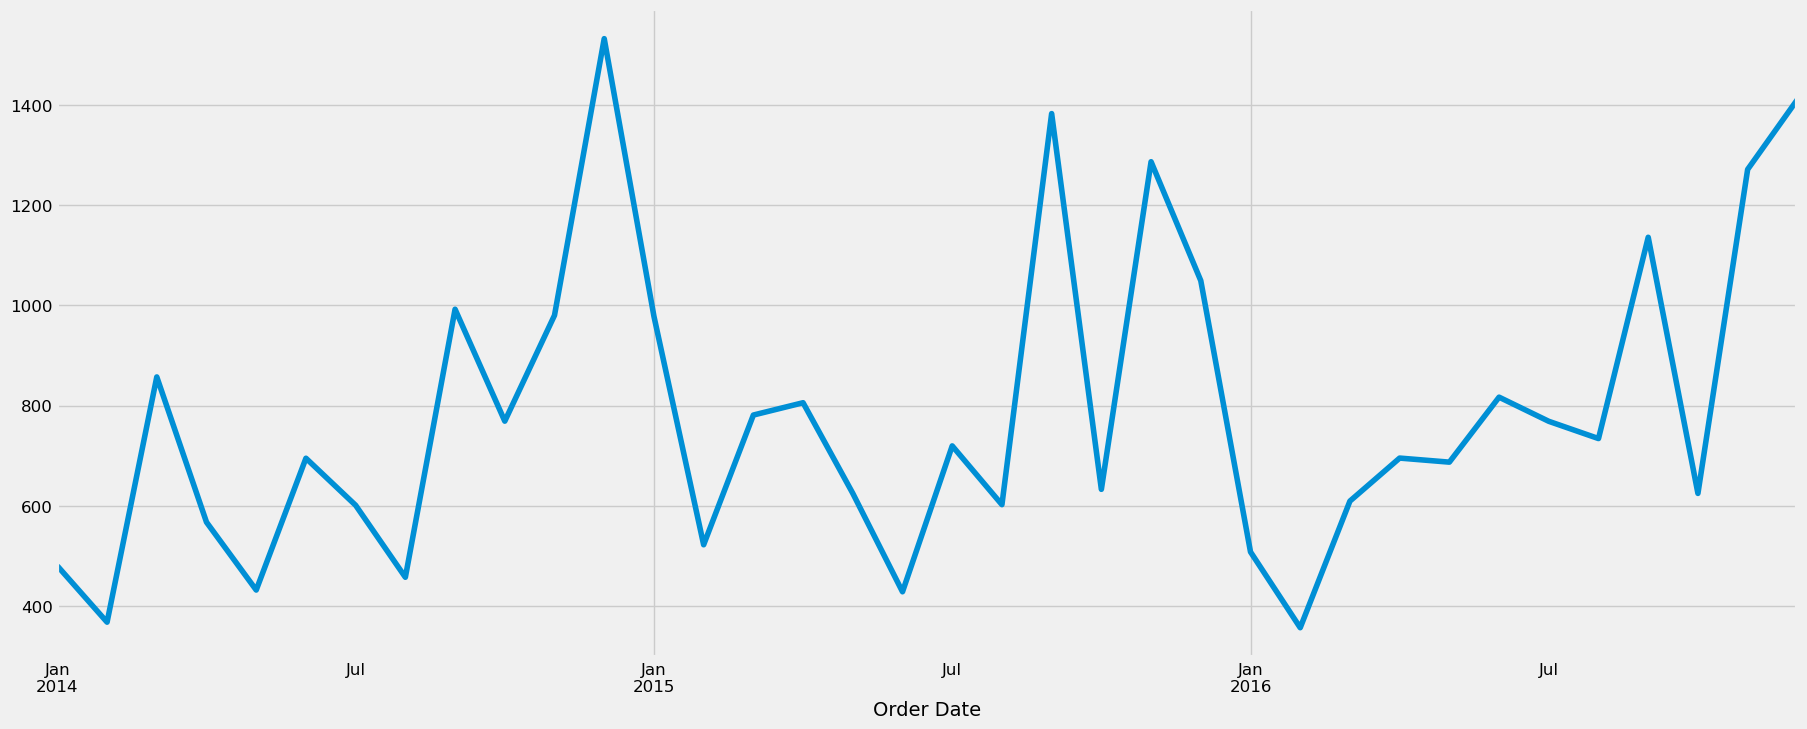

In [11]:
train.plot(figsize=(20, 8))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a time series decomposition that allows us to decompose our time series into four distinct components: level, trend, seasonality, and noise.

A time series can be broke into Systematic Components that have consistency or recurrence and can be described and modeled and Non-Systematic Components that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

[Reference](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

We can visualise our data using time series decomposition.

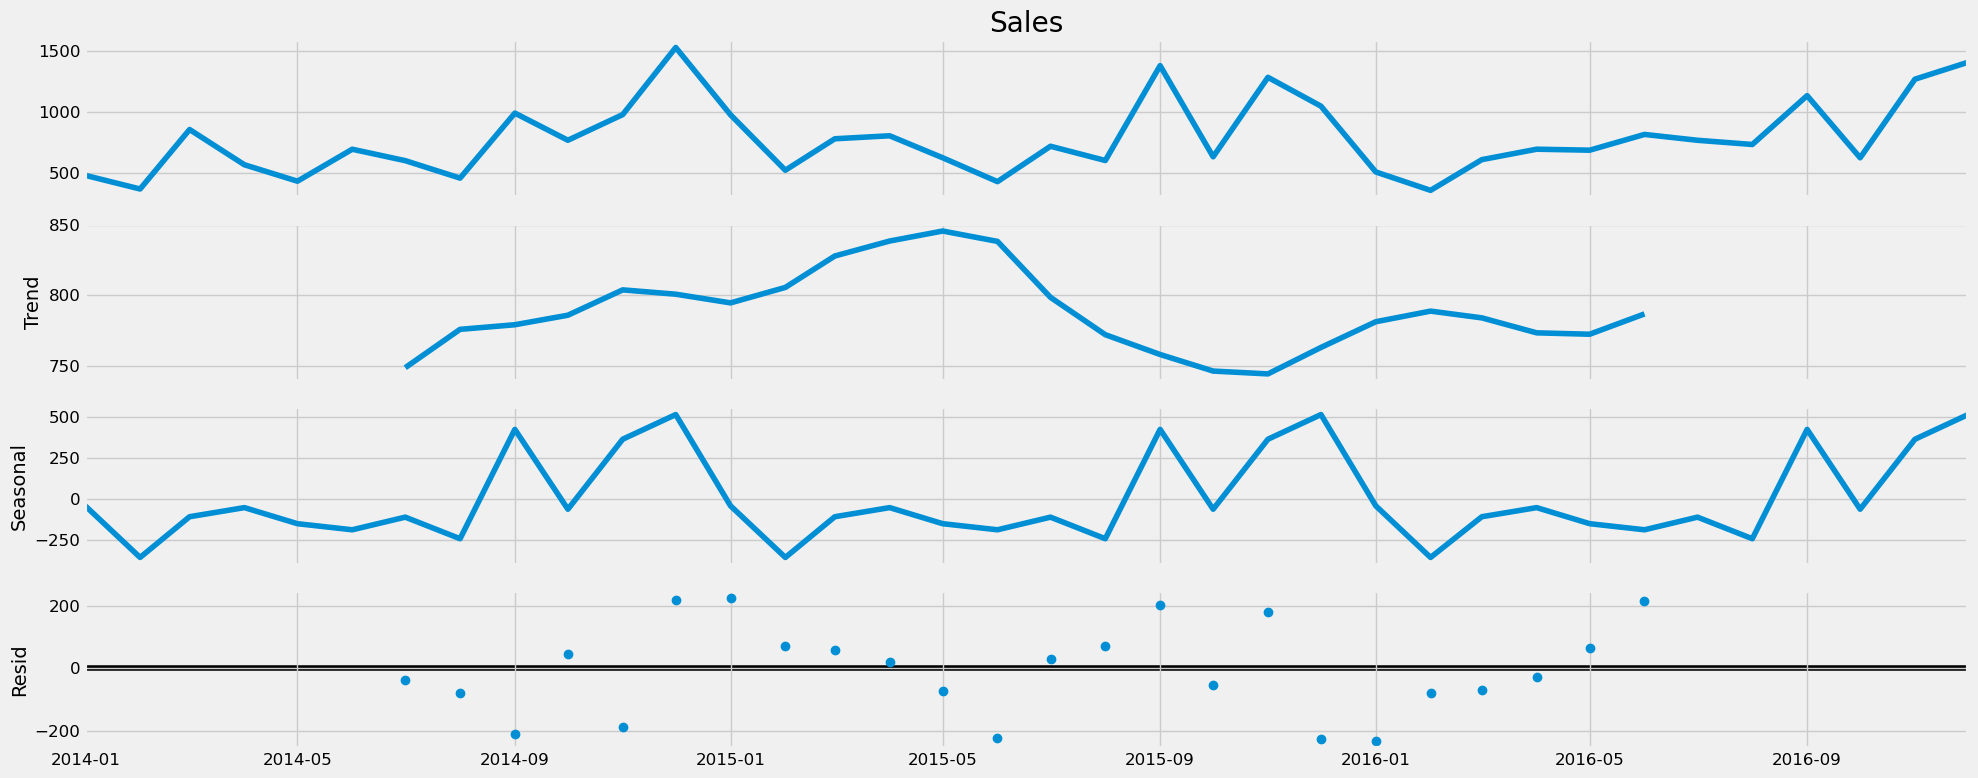

In [12]:
# set figure size
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

# time series decompose
# statsmodels.tsa is a module within the StatsModels library in Python, which stands for "Time Series Analysis."
# StatsModels provides utilities for plotting time series data, decomposing time series into trend, seasonal, and residual components
# and performing statistical tests for stationarity and autocorrelation.
decomposition = sm.tsa.seasonal_decompose(train, model='additive')

# plot
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

# Time series forecasting with SARIMA (Seasonal Autoregressive Integrated Moving Average)

In the context of ARIMA (Autoregressive Integrated Moving Average) models, the parameters $p$, $d$, and $q$ represent the orders of autoregression, differencing, and moving average, respectively.

1. $p$ (Autoregressive Order): This parameter represents the number of lag observations included in the model. It indicates the number of previous time steps to consider for predicting the current value. A higher $p$ value means the model will consider more past observations.

2. $d$ (Differencing Order): This parameter represents the degree of differencing. It is the number of times the raw observations are differenced (i.e., subtracting an observation from the observation at the previous time step). Differencing is used to make the time series stationary, which is often necessary for modeling with ARIMA. A stationary time series has constant mean, variance, and autocorrelation over time.

3. $q$ (Moving Average Order): This parameter represents the size of the moving average window, i.e., the number of lag terms to include in the moving average part of the model. Each term represents the error of the model as a linear combination of error terms from previous observations. A higher $q$ value means the model will consider more past forecast errors.

1. **ARIMA (AutoRegressive Integrated Moving Average)**:
   - ARIMA models are a class of models that include autoregressive (AR), differencing (I), and moving average (MA) components.
   - The ARIMA model is specified by three main parameters: $p$, $d$, and $q$, which correspond to the autoregressive order, differencing order, and moving average order, respectively.
   - ARIMA models are suitable for non-seasonal time series data.

2. **SARIMA (Seasonal AutoRegressive Integrated Moving Average)**:
   - SARIMA models extend ARIMA models to account for seasonality in the time series data.
   - In addition to the parameters $p$, $d$, and $q$ for the non-seasonal components, SARIMA models include additional seasonal parameters: $P$, $D$, $Q$, and $s$, where $P$, $D$, and $Q$ are the seasonal autoregressive, differencing, and moving average orders, respectively, and $s$ is the length of the seasonal cycle (e.g., 12 for monthly data).
   - SARIMA models are suitable for time series data that exhibit seasonal patterns.

3. **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)**:
   - SARIMAX models are an extension of SARIMA models that allow for the inclusion of exogenous variables, which are external factors that can influence the time series data.

In [13]:
# Set up parameter combinations for a SARIMA model.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) #itertools.product computes the Cartesian product of input iterables
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] #the data is monthly and exhibits yearly seasonality, s would typically be 12.

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Then, we perform a grid search over the parameter combinations generated earlier (pdq for non-seasonal parameters and seasonal_pdq for seasonal parameters) to fit SARIMA models to a the 4-year furniture sales time series data.

In [14]:
import warnings
warnings.filterwarnings("ignore")
aic = {'param':[], 'param_seasonal':[], 'AIC':[]}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param, #(p, d, q)
                                            seasonal_order=param_seasonal, #(p, d, q, s)
                                            enforce_stationarity=False, #mean, variance, and autocorrelation structure do not change over time
                                            enforce_invertibility=False) #past values of the series can be expressed as a linear combination of past error terms
            train_result = mod.fit(disp=False)
            aic['param'].append(param)
            aic['param_seasonal'].append(param_seasonal)
            aic['AIC'].append(train_result.aic)
            #Lower AIC values indicate a better trade-off between goodness of fit and model complexity
        except:
            continue
idx = aic['AIC'].index(min(aic['AIC']))
print('The model SARIMAX{}x{} has the lowest AIC value of {}'.format(aic['param'][idx], aic['param_seasonal'][idx], aic['AIC'][idx]))

The model SARIMAX(1, 1, 1)x(0, 1, 1, 12) has the lowest AIC value of 122.3154887424066


# Fitting the SARIMAX model

In [15]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
# results.summary()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2559      0.387      0.660      0.509      -0.504       1.015
ma.L1         -1.0000   1285.630     -0.001      0.999   -2520.788    2518.788
ma.S.L12      -0.9999   1285.459     -0.001      0.999   -2520.452    2518.453
sigma2      1.164e+04      0.101   1.15e+05      0.000    1.16e+04    1.16e+04


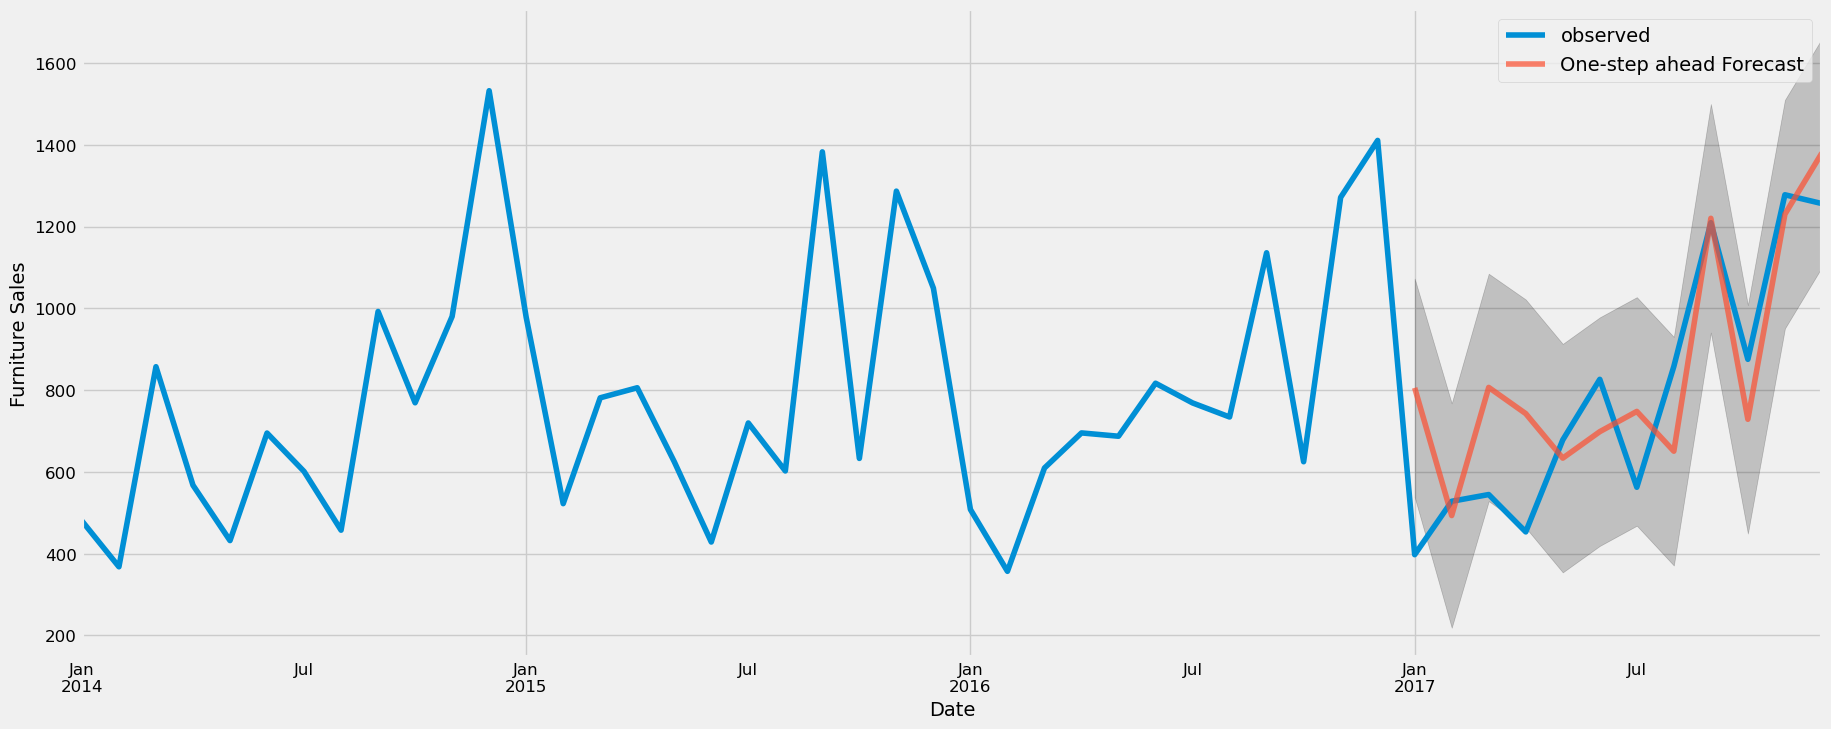

In [16]:
# pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_ci = pred.conf_int()
ax = furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [17]:
test_forecasted = pred.predicted_mean
test_truth = test['2017-01-01':]
mse = ((test_forecasted - test_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 37910.37


In [18]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 194.71


# Producing and visualizing forecasts

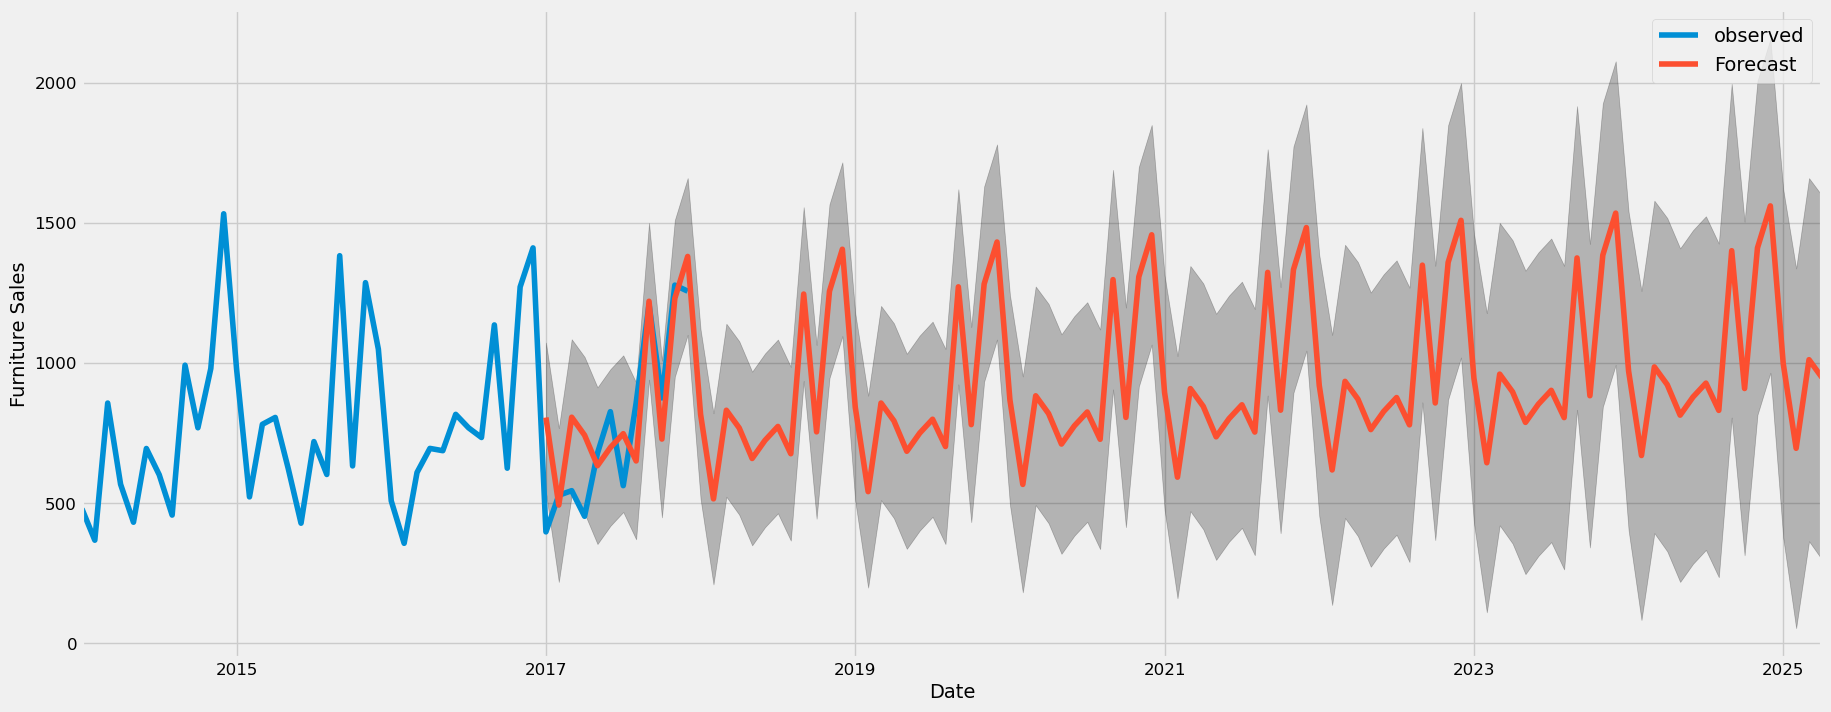

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = furniture.plot(label='observed', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier.

# Time Series of Furniture vs. Office Supplies

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [20]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

# Data Exploration

We are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

In [21]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 
        'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


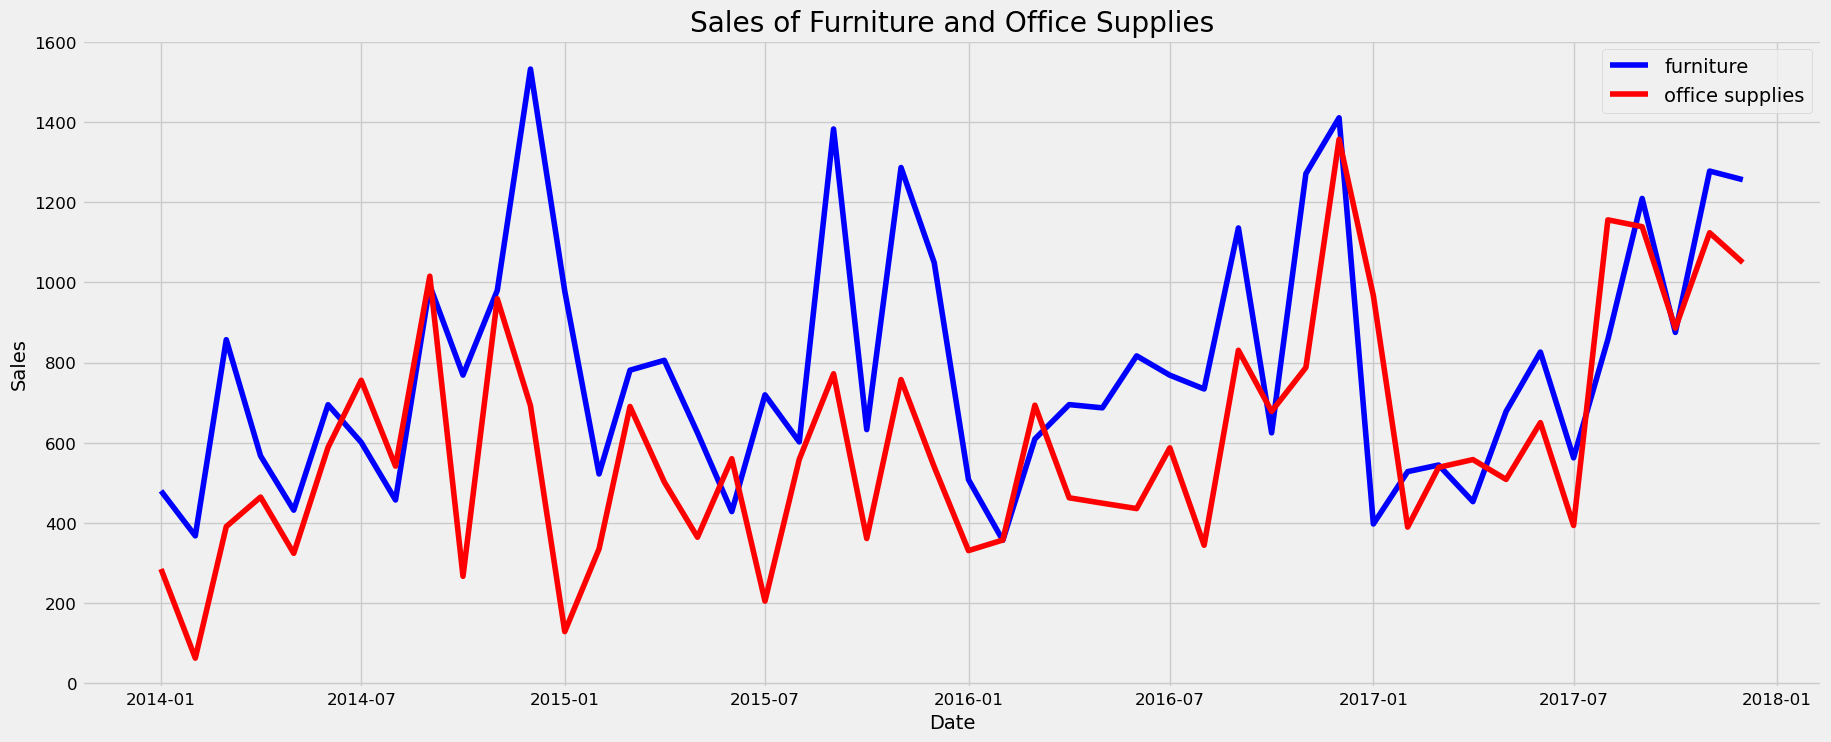

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. In addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales.

# Time Series Modeling with Prophet

Importing plotly failed. Interactive plots will not work.
12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1] done processing
12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 2000x800 with 0 Axes>

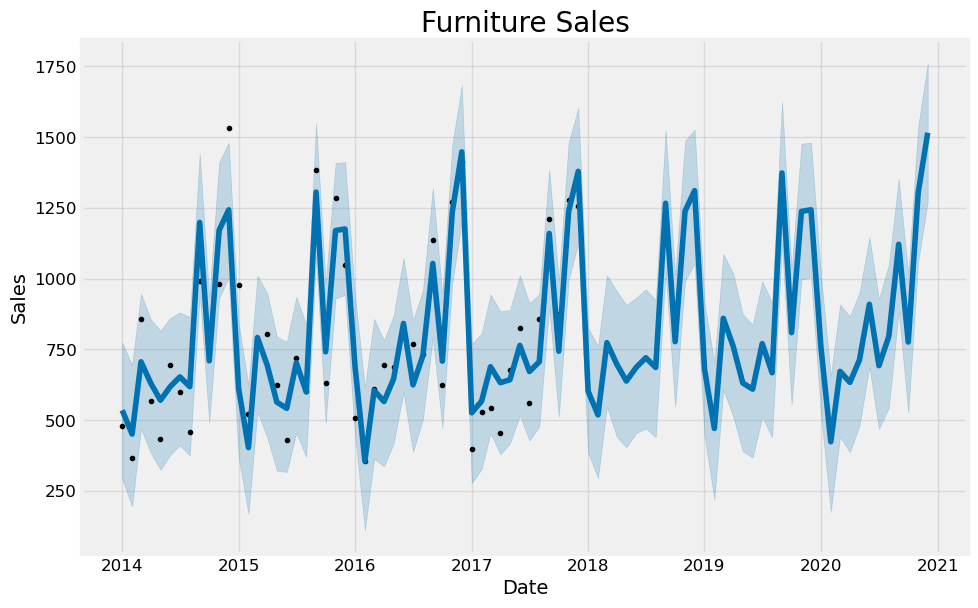

In [23]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'}) #rename columns for use with the Prophet library
furniture_model = Prophet(interval_width=0.95) #want the prediction intervals to cover approximately 95% of the uncertainty around the forecasted values
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS') #36 months
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

plt.figure(figsize=(20, 8))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 2000x800 with 0 Axes>

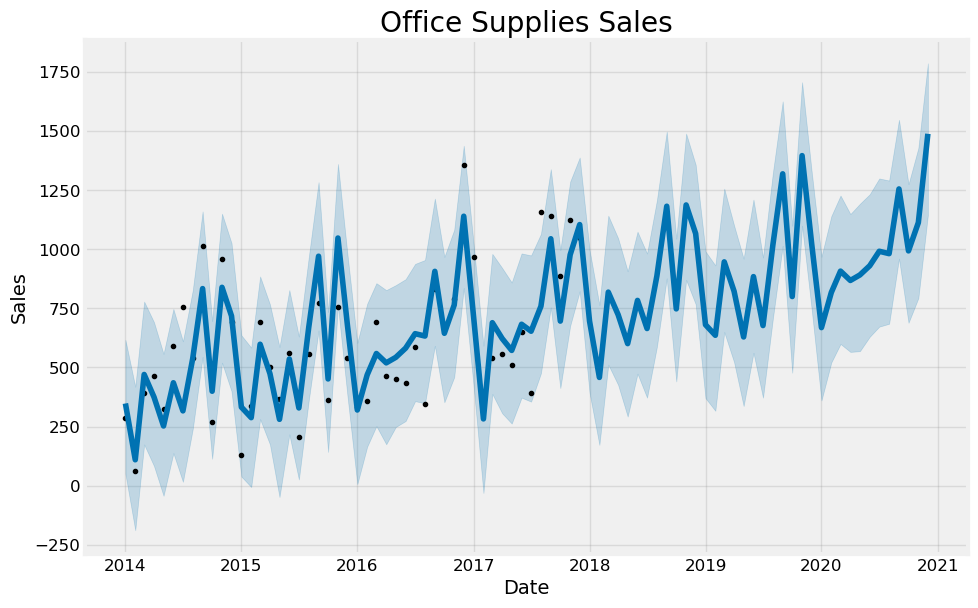

In [24]:
plt.figure(figsize=(20, 8))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# Compare Forecasts
We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [25]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,290.920120,774.089241,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,-190.686099,-190.686099,0.0,0.0,0.0,535.372010,487.530485,49.804301,616.707760,487.530485,487.530485,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,195.729309,695.037314,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,-276.379157,-276.379157,0.0,0.0,0.0,451.115264,494.918166,-188.879688,418.178315,494.918166,494.918166,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,470.733044,947.440499,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,-22.388253,-22.388253,0.0,0.0,0.0,706.403481,501.590911,174.053176,778.652894,501.590911,501.590911,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,383.386829,855.499961,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,-100.140909,-100.140909,0.0,0.0,0.0,630.087137,508.978592,82.873113,691.178728,508.978592,508.978592,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,324.868929,816.182777,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,-160.818882,-160.818882,0.0,0.0,0.0,570.799142,516.127962,-43.121057,557.194328,516.127962,516.127962,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


# Trend and Forecast Visualization

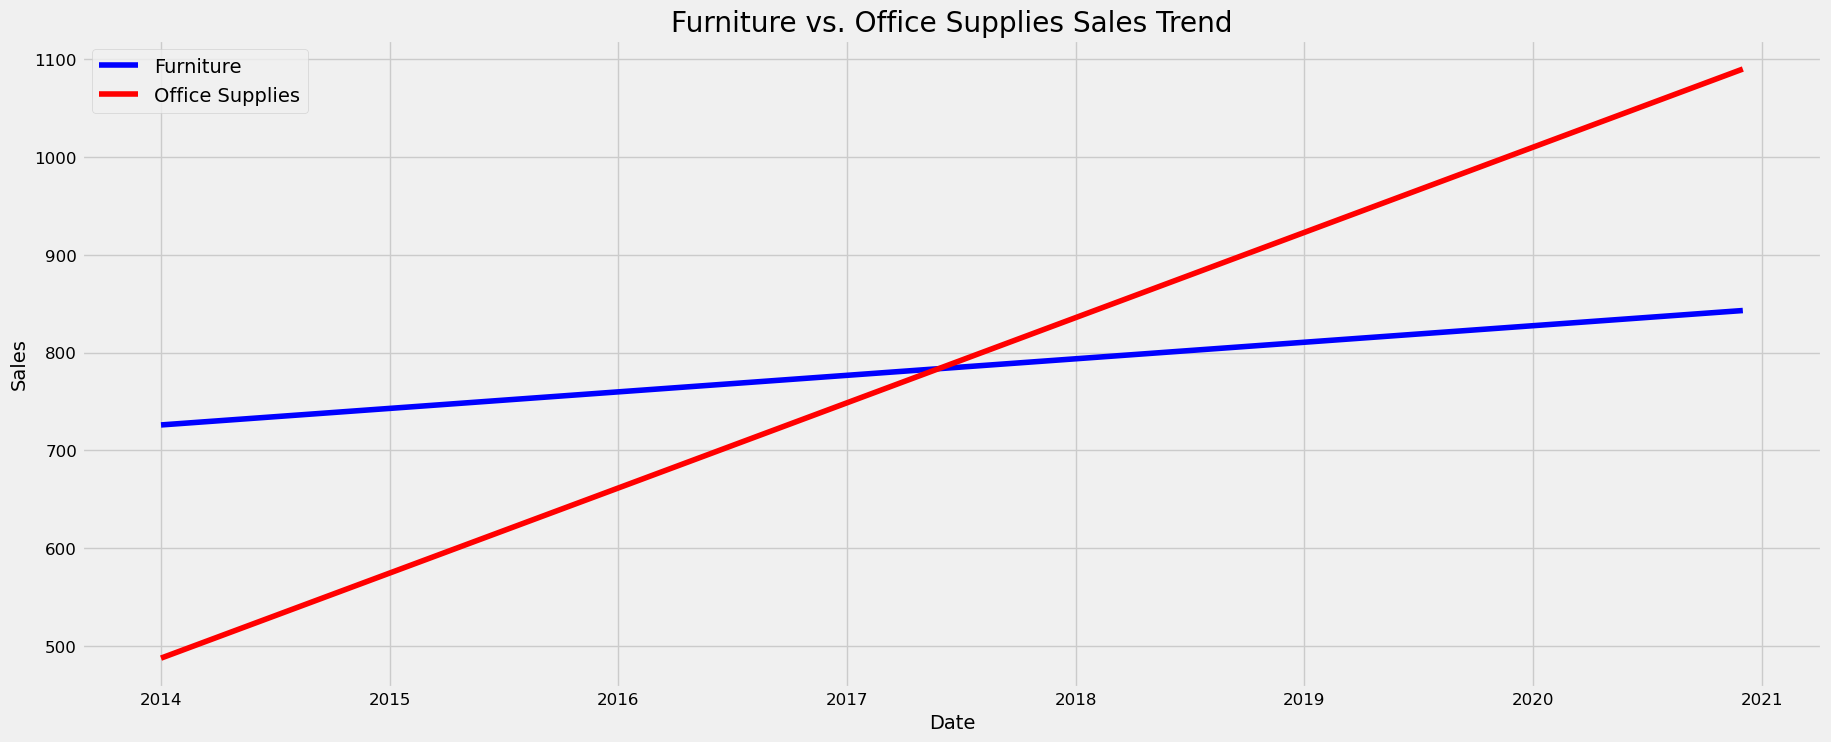

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label='Furniture')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-', label='Office Supplies')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

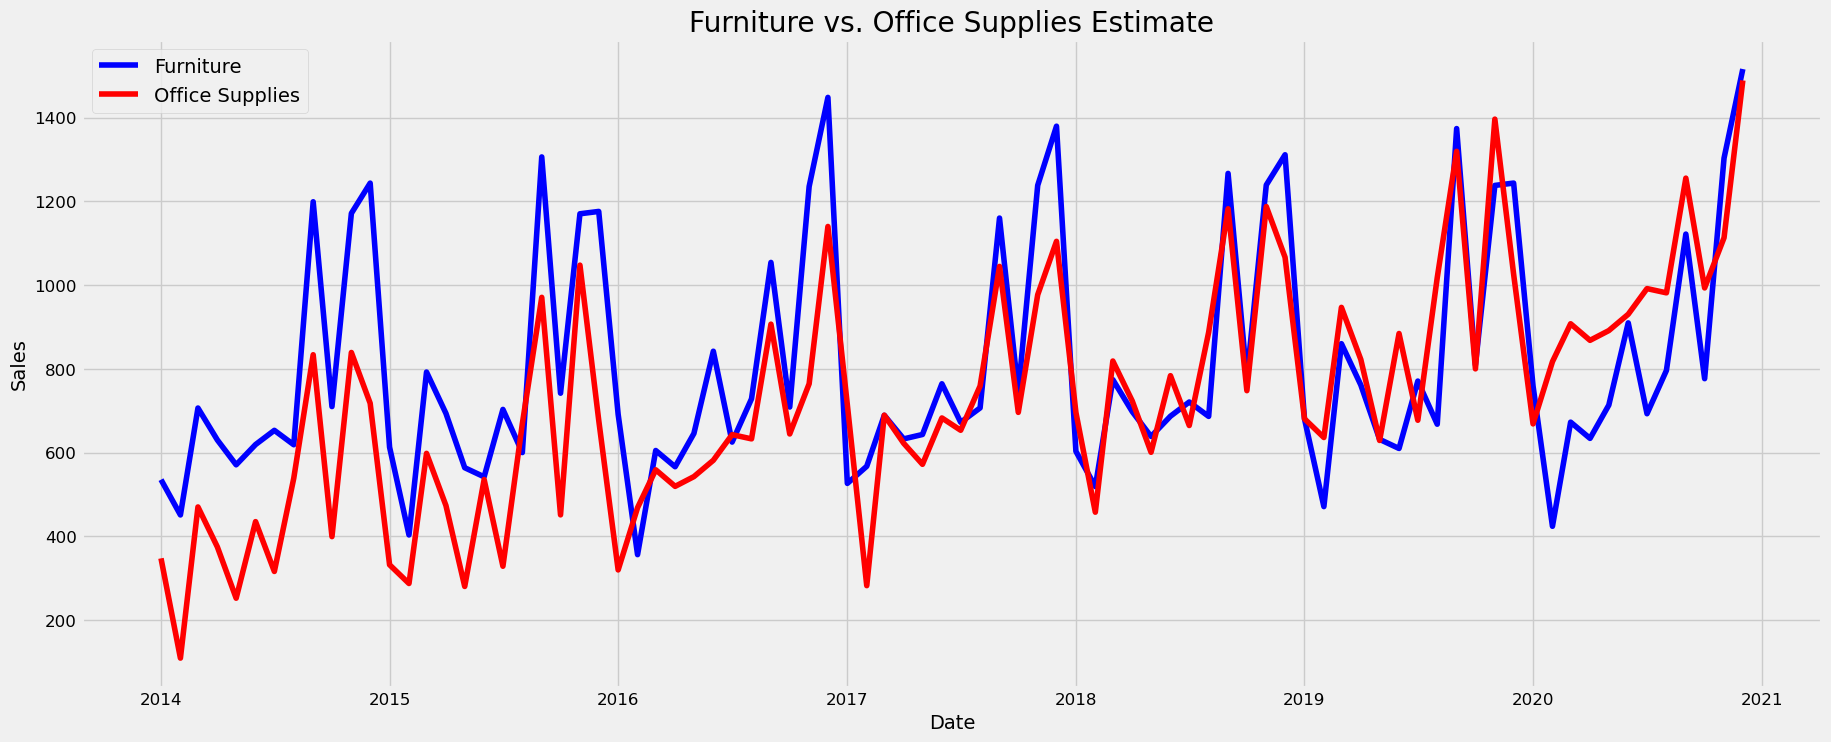

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label='Furniture')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-', label='Office Supplies')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

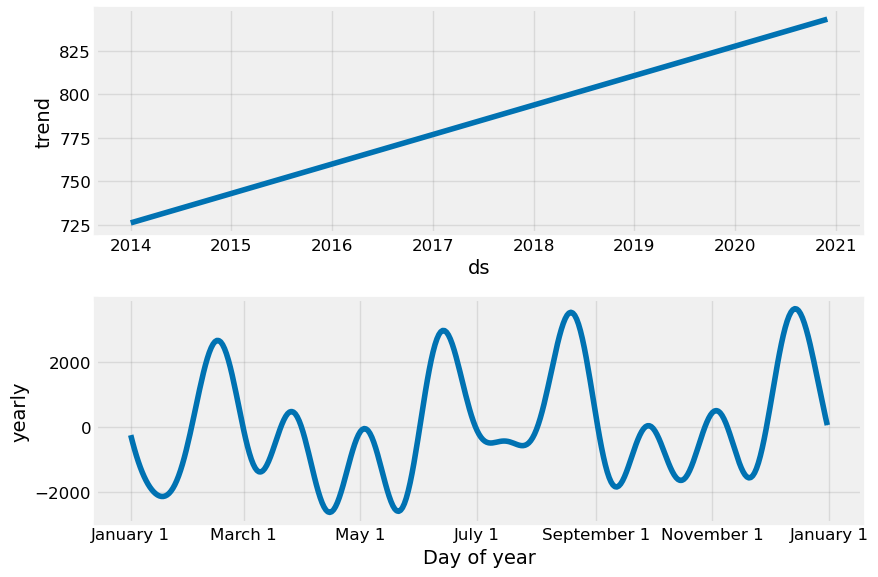

In [33]:
furniture_model.plot_components(furniture_forecast);

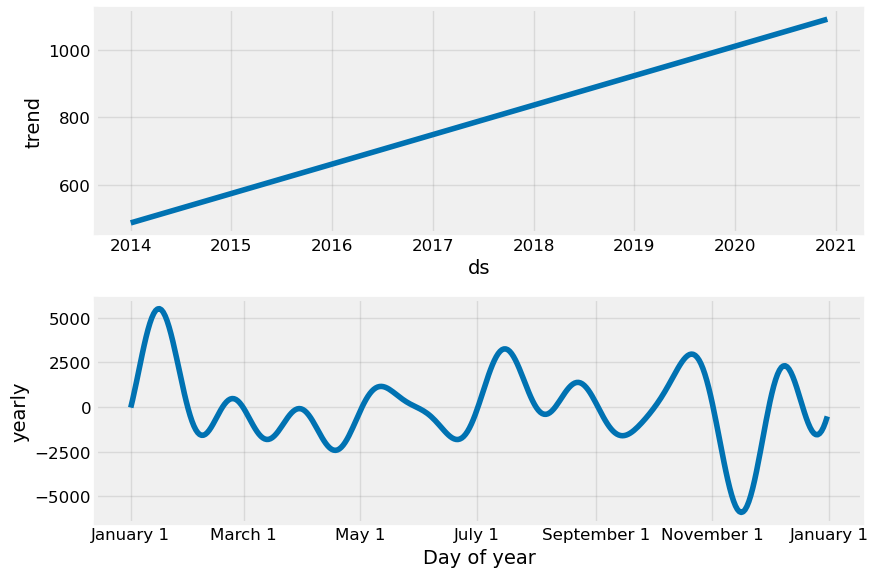

In [34]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.\
The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.\
There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.

# Package installing and Virtual Environment

[How to add your Conda environment to your jupyter notebook in just 4 steps](https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084)\
[Installing FBProphet/Prophet for Time Series Forecasting in Jupyter Notebook](https://medium.com/data-folks-indonesia/installing-fbprophet-prophet-for-time-series-forecasting-in-jupyter-notebook-7de6db09f93e)